# Conditional Evolution of Helix-Rastrigin Problem by Novelty-Metric

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import itertools as it

## Use Objective Wrapper
- to minimize different `foo`s
- or `maximize` them.
- In the latter case, we may need to specify numerical limits to constraint the search-space

### Implement `NoveltyCondition` Class
- a condition should be derived from `condevo.es.Condition`.
- In the `evaluate` method, we evaluate the novelty score based on a nearest neighbor metric to all samples in the buffer.
- In the `sample`, we sample conditions with large novelty scores from a Boltzmann distribution, and we apply noise to the condition samples.
- The condition instances is then passed in a tuple of conditions to the `condevo.es.CHARLES` constructor.
- In the `benchmark.run` wrapper, we also apply JSON dumps for the `condevo.es.CHARLES` kwargs, thus a `to_dict` method is implemented.

In [3]:
from condevo.es.guidance import Condition, KNNNoveltyCondition, FitnessCondition
from benchmark import utils, configs, run
from run_novelty import get_objective, run_experiments
from condevo.stats import grid_entropy_2d

### Perform `"CHARLES"` optimization with the `benchmark.run` Wrapper
- different `es` implementations might be used, and configured via the `es_config` dictionary parameter
- different `diff` diffusion models (DMs) might be used (below we use `"RectFlow"`. Again, the DM can be configured with a `diff_config` dictionary (default configs are located in the `configs` module for all available `diff` DMs.)
- different `nn` neural networks might be used, and configured with the `nn_config` dictionary.
- a destination path `dst` for the output `hdf5` files (logging population parameters, fitness and model loss for every generation for every separate evolutionary run) might be specified, but defaults to `utils.DST`. The `hdf5` files follow a naming scheme defined by `utils.H5_FILE`.
- the evaluation can be turned `quiet`
- see documentation of `run` for more info

In [4]:
#objective, targets = get_objective("spiral_peaks"), np.array(((1.751, 1.785), (-1.751, -1.785)))
#objective, targets = get_objective("rastrigin"), np.array(((-3.5, -3.5), (-3.5, 3.5), (3.5, -3.5), (3.5, 3.5)))
objective, targets = get_objective("helix_rastrigin"), np.array(((-1.37, -4.8), (-4.8, 1.37), (1.37, 4.8), (4.8, -1.37)))
#objective, targets = get_objective("himmelblau"), np.array(((3., 2.0), (-2.81, 3.13), (-3.78, -3.28), (3.58, -1.85)))

/home/bene/anaconda3/envs/condevo/lib/python3.8/site-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


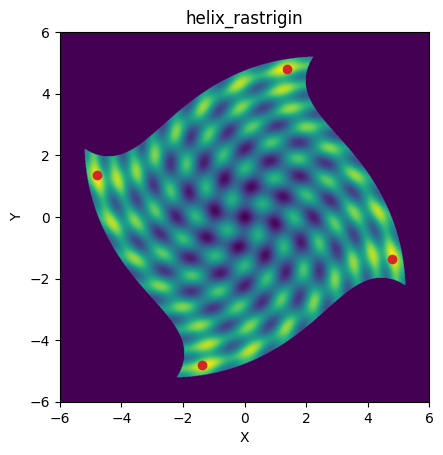

In [5]:
from foobench import Objective
from foobench.plot import visualize_2D

ax = plt.gca()
visualize_2D(objective, parameter_range=6, ax=ax, n_points=1001)
ax.scatter(*targets.T, color="tab:red")

In [6]:
DST = utils.DST + '/paper_HADES/experiment_novelty/'
KWS = {"objective": "helix_rastrigin", "niter": 50, "dst": DST}
KNN = 128

In [7]:
DST_baseline = DST + "/baseline"
DST_fisher = DST + "/charles_fisher"
DST_greedy = DST + "/charles_greedy"
DST_novelty = DST + f"/novelty_{KNN}"
DST_novelty_fisher = DST + f"/novelty_{KNN}-charles_fisher"
DST_novelty_greedy = DST + f"/novelty_{KNN}-charles_greedy"

### Generate Data
The following can be expensive; data from HADES publication can be accessed [here](https://tufts.box.com/s/wnqs9levqm23zb4d6wo7hyi9etbodhjx),
follow provided extraction instructions.

In [8]:
#rc = run_experiments(**kws)
#rc_fisher = run_experiments(conditions="fisher", **KWS)
#rc_greedy = run_experiments("greedy", **KWS)
#rc_novelty = run_experiments(conditions=f"{KNN}", **KWS)
#rc_novelty_fisher = run_experiments(conditions=f"{KNN}-fisher", **KWS)
# rc_novelty_greedy = run_experiments(conditions=f"{KNN}-greedy", **KWS)
#rc_cma = run_experiments(es="CMAES", **KWS)
#rc_simplega = run_experiments(es="SimpleGA", **KWS)
#rc_MScma = run_experiments(es="MultistartCMA", **KWS)

### Load Data
Data from HADES publication can be accessed [here](https://tufts.box.com/s/wnqs9levqm23zb4d6wo7hyi9etbodhjx),
follow provided extraction instructions.

In [9]:
from analysis import load_benchmark

df_baseline = load_benchmark(objective=objective.foo_name, es="CHARLES", dst=DST_baseline)
df_cma = load_benchmark(objective=objective.foo_name, es="CMAES", dst=DST_baseline)
df_MScma = load_benchmark(objective=objective.foo_name, es="MultistartES", dst=DST_baseline)
df_simplega = load_benchmark(objective=objective.foo_name, es="SimpleGA", dst=DST_baseline)
df_fisher = load_benchmark(objective=objective.foo_name, es="CHARLES", dst=DST_fisher)
df_greedy = load_benchmark(objective=objective.foo_name, es="CHARLES", dst=DST_greedy)
df_novelty = load_benchmark(objective=objective.foo_name, es="CHARLES", dst=DST_novelty)
df_novelty_fisher = load_benchmark(objective=objective.foo_name, es="CHARLES", dst=DST_novelty_fisher)
df_novelty_greedy = load_benchmark(objective=objective.foo_name, es="CHARLES", dst=DST_novelty_greedy)

loading data from data/es_benchmark/optimize/paper_HADES/experiment_novelty//baseline/ES_CHARLES-objective_helix_rastrigin-20241029174104485.h5
found runs: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
loading data from data/es_benchmark/optimize/paper_HADES/experiment_novelty//baseline/ES_CHARLES-objective_helix_rastrigin-20241029174115471.h5
found runs: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
no runs found in file data/es_benchmark/optimize/paper_HADES/experiment_novelty//baseline/ES_CHARLES-objective_helix_rastrigin-20241029174115471.h5
loading data from data/es_benchmark/optimize/paper_HADES/experiment_novelty//baseline/ES_CHARLES-objective_helix_rastrigin-20241029174124893.h5
found runs: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
no runs found in file data/es_benchmark/optimize/paper_HADES/experiment_novelty//baseline/ES_CHARLES-objective_helix_rastrigin-20241029174124893.h5
loading data from data/es_benchmark/optimize/paper_HADES/experiment_novelty//baseline/ES_CHARLES-objective_helix_rastri

### Analyze Data

In [10]:
max_len = 100

In [11]:
dfs = [df_baseline, df_fisher, df_greedy, df_novelty, df_novelty_fisher, df_novelty_greedy]
for i, df in enumerate(dfs):
    to_del = []
    for r, df_r in df.groupby("run"):
        if np.any(np.isnan([s for s in df_r["samples"].values])):
            to_del.extend(df_r.index)

        elif df_r["gen"].max() < max_len:
            print(f"del {r}", df_r["gen"].max())
            to_del.extend(df_r.index)
    
    dfs[i] = df.drop(index=to_del) 
    
df_baseline, df_fisher, df_greedy, df_novelty, df_novelty_fisher, df_novelty_greedy = dfs

del 11 9
del 10 34
del 10 33
del 21 13
del 32 0
del 4 37
del 9 55
del 14 46
del 19 37
del 24 36
del 4 27
del 9 49
del 14 38
del 19 28
del 24 22
del 4 28
del 9 42
del 14 31
del 19 26
del 24 23


In [13]:
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import pdist

def get_cumulative_target_hits(df, threshold=10):
    num_hits = []
    for r, df_r in df.groupby("run"):
        df_r = df_r.sort_values("gen")

        samples = np.array([si for si in df_r.samples])
        fitness = np.array([fi for fi in df_r.fitness])

        generations = len(samples)
        target_hit = np.zeros((generations, len(targets)))
        for i, t in enumerate(targets):
            dt = np.linalg.norm((samples - t), axis=-1)  # distance to peak
            hits = np.sum(dt < 0.25, axis=-1)            # distance closer than treshold, summed across population
            # print(hits)
            target_hit[:, i] = np.cumsum(hits)

        threshold_hit = target_hit > threshold
        num_hits.append(threshold_hit.sum(axis=1))

    return np.array(num_hits)


def get_data(df):
    p = np.array((1., 1.))
    p = p[:] / np.linalg.norm(p)
    
    d_best = []
    d_mu = []
    d_std = []
    d_fit = []    
    d_gens = []
    d_entropy = []
    d_meandist = []
    d_cosim = []
    d_final = []
    d_elites = []
    d_target = []
    for r, df_r in df.groupby("run"):
        try:
            df_r = df_r.sort_values("gen")
            d_r = np.array([s.dot(p) for s in df_r["samples"]])    

            d_q = []
            for ti in targets:
                d_q.append(np.array([s - ti for s in df_r["samples"]]))

            d_f = np.array([f for f in df_r["fitness"]])
            d_fbest = d_f.argmax(axis=1)
            d_best.append([d_ri[b] for d_ri, b in zip(d_r, d_fbest)])    
            g_r = np.array([[gi] * d_r.shape[1] for gi in df_r["gen"]])       
            d_mu.append(d_r.mean(axis=1))
            d_std.append(d_r.std(axis=1))
            
            d_entropy.append([grid_entropy_2d(d_ri, grid_size=101, range_min=-6, range_max=6)
                              for d_ri in df_r["samples"]])
            
            pairwise_distance = np.array([pdist(generation).mean() for generation in df_r["samples"]])
            d_meandist.append(pairwise_distance)

            cosine_similarity_matrix = [cosine_similarity(generation) for generation in df_r["samples"]]
            triu_indices = np.triu_indices_from(cosine_similarity_matrix[0], k=1)
            d_cosim.append(np.array([c[triu_indices].mean() for c in cosine_similarity_matrix]))
            
            d_fit.append(d_f)
            d_gens.append(g_r)
            
            top_k = d_f.flatten()  # .argsort()[::-1]
            top_k = top_k >= (top_k.max() * 0.9)
            #top_k = top_k[:int(len(top_k)//10)]
            #top_k = top_k[top_k]
            elites = np.concatenate(df_r["samples"].values, axis=0)[top_k]
            d_elites.append(elites)

            d_final.append(df_r["samples"].values[-2])
            d_target.append([np.linalg.norm(d_qi, axis=-1) for d_qi in d_q])
        except IndexError:
            pass
    
    cumulative_target = get_cumulative_target_hits(df)

    return {"best": d_best, "mu": d_mu, "std": d_std, "gens": d_gens, 
            "entropy": d_entropy, 
            "cosim": d_cosim, 
            "meandist": d_meandist, 
            "fitness": d_fit, "final": d_final, "d_target": d_target, "cumulative_target": cumulative_target, "elites": d_elites}
    

#p1_best, p1_mu, p1_std, p1_gens = get_data(df_baseline, color="tab:red", ax=ax1)
print("baseline")
data_baseline = get_data(df_baseline,)

print("Fisher")
data_fisher = get_data(df_fisher, )

print("Greedy")
data_greedy = get_data(df_greedy, )

print("Novelty")
data_novelty = get_data(df_novelty, )

print("Novelty Fisher")
data_novelty_fisher = get_data(df_novelty_fisher, )

print("Novelty Greedy")
data_novelty_greedy = get_data(df_novelty_greedy, )

print("CMA")
data_cma = get_data(df_cma, )

print("SimpleGA")
data_simplega = get_data(df_simplega,)


baseline
Fisher
Greedy
Novelty
Novelty Fisher
Novelty Greedy
CMA
SimpleGA


In [14]:
print("MultistartCMA")
data_multistartcma = get_data(df_MScma,)

MultistartCMA


In [15]:
for k, v in data_greedy.items():
    print(k, len(v))

best 52
mu 52
std 52
gens 52
entropy 52
cosim 52
meandist 52
fitness 52
final 52
d_target 52
cumulative_target 52
elites 52


In [16]:
for data in (data_baseline, 
             data_fisher, 
             data_greedy, 
             data_novelty, 
             data_novelty_fisher, 
             data_novelty_greedy, 
             #data_cma, data_simplega,
            ):
    
    keys = list(data.keys())
    for k in keys:
        v = data[k]
        if k == "d_target":
            # num_targets, num_generations, population_size
            data[k] = [np.array(d)[:, :max_len] for d in v]
        else:
            data[k] = [d[:max_len] for i, d in enumerate(v)]

    shape_0 = np.shape(data["best"][0])[0]
    to_del = []
    for i in range(len(data["best"])):
        if np.shape(data["best"][i])[0] != shape_0:
            to_del.append(i)
    
    to_del = list(reversed(sorted(to_del)))
    keys = list(data.keys())
    for k in keys:
        v = data[k]
        data[k] = [d for i, d in enumerate(v) if i not in to_del]


64.6248819545208


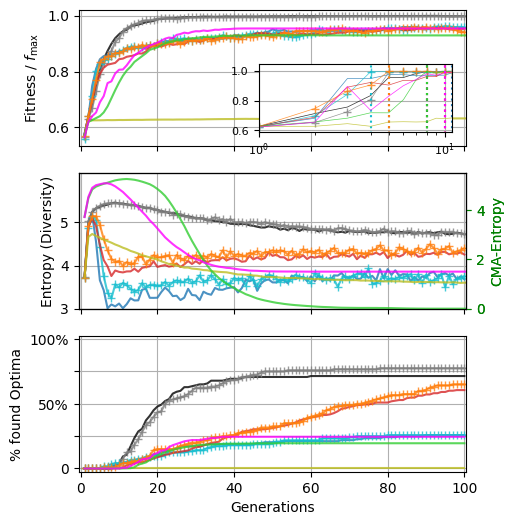

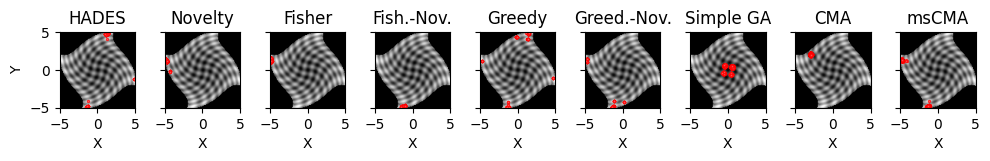

In [17]:
dataset = ((data_baseline,       "HADES",        0, "black",      "-", "none"),
           (data_novelty,        "Novelty",      0, "gray",       "-", "+"), 
           (data_fisher,         "Fisher",       0, "tab:blue",   "-", "none"),
           (data_novelty_fisher, "Fish.-Nov.",   0, "tab:cyan",   "-", "+"), 
           (data_greedy,         "Greedy",       0, "tab:red",    "-", "none"), 
           (data_novelty_greedy, "Greed.-Nov.",  0, "tab:orange", "-", "+"), 
           (data_simplega,       "Simple GA",    0, "tab:olive",  "-", "none"),
           (data_cma,            "CMA",          0, "limegreen",  "-", "none"), 
           (data_multistartcma,  "msCMA",        0, "magenta",    "-", "none"),
         )

f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(5, 6), sharex=True)
ax1.set_ylabel("Fitness / $f_{\\mathrm{max}}$")
ax2.set_ylabel("Entropy (Diversity)")
ax3.set_ylabel("% found Optima")
ax3.set_xlabel("Generations")

from mpl_toolkits.axes_grid1.inset_locator import inset_axes
ax1ins = inset_axes(ax1, width="50%", height="50%", loc=4, borderpad=1)
f1, axes = plt.subplots(1, len(dataset), figsize=(10, 2), sharex=True, sharey=True)

f_max = max([np.max(df["fitness"]) for df, *_ in dataset])
print(f_max)

for i, (data, label, run_id, color, ls, marker) in enumerate(dataset):
    gens = data["gens"][0][:, 0] + 1
    y_raw = np.max(data["fitness"], axis=-1)
    y_mean = np.mean(y_raw, axis=0) / f_max
    y_max = np.max(y_raw, axis=0) / f_max
    ax1.plot(gens, y_mean, label=label, marker=marker, linestyle=ls, alpha=0.8, color=color)
    
    try:
        solution = np.where(y_max > 0.985)[0][0]
        ax1ins.axvline(solution + 1, -1, 1.5, color=color, linestyle=":")
        
    except:
        pass
    
    ax1ins.semilogx(gens, y_max, marker=marker, linestyle=ls, alpha=0.8, color=color, linewidth=0.5)
    ax1ins.set_xlim([1, 11])
    ax1ins.tick_params(axis='x', labelsize=8)
    ax1ins.tick_params(axis='y', labelsize=8)
    ax1ins.set_ylim([0.59, 1.05])
    #ax1.fill_between(gens, y_show, np.max(y_raw, axis=0), alpha=0.2, color=color)
    
    if "CMA" in label.upper():
        ax2b = ax2.twinx()
        ax2b.set_ylabel("CMA-Entropy")
        ax2b.set_ylim([0, 5.5])
        ax2b.tick_params(axis='y', colors="green")  # color)
        ax2b.yaxis.label.set_color("green")  # color)

        y_show = np.mean(data["entropy"], axis=0)
        ax2b.plot(gens, y_show, label=label, color=color, marker=marker, linestyle=ls, alpha=0.8, )

    else:
        ax2.set_ylim([3, 6.15])
        ax2.set_yticks([3, 4, 5, ])

        y_show = np.mean(data["entropy"], axis=0)
        ax2.plot(gens, y_show, label=label, color=color, marker=marker, linestyle=ls, alpha=0.8, )
    
    dp = 0.5 # np.linalg.norm((1, 1))
    fraction = 6
    num_targets = []
    for g, dtarget in zip(data["gens"], data["d_target"]):
        dfound = [np.mean(np.sort(dqi < dp)[:max_len, -fraction:], axis=-1) for dqi in dtarget]
        num_targets.append(np.sum(dfound, axis=0))   

    #ax3.plot(g[:max_len, 0], np.mean(num_targets, axis=0), color=color, marker=".", linestyle="--", alpha=0.8, markeredgecolor="black", markeredgewidth=0.25)
    current_target = np.mean(num_targets, axis=0)
    cumulative_target = np.array([d[:max_len] for d in data["cumulative_target"]])
    ax3.plot(gens[:max_len], np.mean(cumulative_target, axis=0), color=color, marker=marker, linestyle=ls, alpha=0.8, label=label)
    #ax3.fill_between(g[:max_len, 0], np.mean(cumulative_target, axis=0) - np.std(cumulative_target, axis=0), np.mean(cumulative_target, axis=0) + np.std(cumulative_target, axis=0), alpha=0.2, color=color)
    #ax3.plot(g[:max_len, 0], current_target, color=color)
    
    ax3.set_ylim([-0.1, 4.1])

    # good greedy-novel: 0

    run_id = 0
    #run_id = 20
    try:
        visualize_2D(objective, cmap="binary" + ("_r" if not objective.maximize else ""), ax=axes[i], title=label, parameter_range=5)
        # axes[i].scatter(*data["final"][run_id].T, s=2, color="white", alpha=0.8, edgecolors="tab:cyan")
        axes[i].scatter(*data["elites"][run_id].T, s=2, color="white", alpha=0.8, edgecolors="red")
        axes[i].set_xlim([-5, 5])
        axes[i].set_ylim([-5, 5])
        if i != 0:
            axes[i].set_ylabel("")
    except:
        pass
    #y_raw = np.mean(data[key], axis=-1)
    #y_show = np.mean(y_raw, axis=0)
    #plt.plot(gens, y_show, label=label)
    #plt.fill_between(gens, y_show - np.std(y_raw, axis=0), np.max(y_raw, axis=0), alpha=0.2)

[ax.grid() for ax in (ax1, ax2, ax3)]
ax1ins.grid(which="major")

#ax3.legend()
ax1.set_xlim([-0.5, max_len + 0.5])
f1.tight_layout()

ax3.set_yticks([0, 1, 2, 3, 4], ["0", "", "50%", "", "100%"]) 

# f1.savefig(f"local/img/novelty_{objective.foo_name}_solutions.png", dpi=300)
f.savefig(f"local/img/novelty_{objective.foo_name}_diversity_fitness.pdf")
#plt.semilogx()

/tmp/ipykernel_48866/3980447353.py:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([-4, 0, 4])


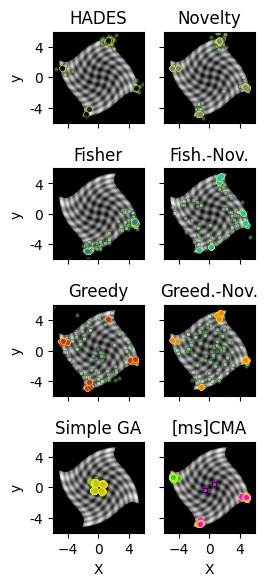

In [36]:
dataset = ((data_baseline,       "HADES",        11, "black",      "-", "none"),  # 8 (4)
           (data_novelty,        "Novelty",      9, "gray",       "-", "+"),     # 1 (4)
           (data_fisher,         "Fisher",       26, "tab:blue",   "-", "none"),  # 5 (2) 12, 26
           (data_novelty_fisher, "Fish.-Nov.",   13, "tab:cyan",   "-", "+"),     # 13 (2)
           (data_greedy,         "Greedy",       18, "tab:red",    "-", "none"),  # 8 (4), 22(4), 28 (4), 34 (4), 42 (4)  # 0, 6
           (data_novelty_greedy, "Greed.-Nov.",  6, "tab:orange", "-", "+"),     # 0 (4), 15(4), 22 (4), 23 (4)
           (data_simplega,       "Simple GA",    2, "tab:olive",  "-", "none"),
           (data_cma,            "CMA",          3, "limegreen",  "-", "none"),   # 3 (1), 5, 
         )

f1, axes = plt.subplots(len(dataset) // 2, 2, figsize=(2.75, 6), sharex=True, sharey=True)
# f1, axes = plt.subplots(2, len(dataset) // 2, figsize=(10, 5), sharex=True, sharey=True)
axes = axes.flatten()

for i, (data, label, run_id, color, ls, marker) in enumerate(dataset):
    try:
        visualize_2D(objective, cmap="binary" + ("_r" if not objective.maximize else ""), ax=axes[i], title=label, parameter_range=6, n_points=201)
        axes[i].scatter(*data["final"][run_id].T, s=10, color="lightgreen", alpha=0.4, edgecolors="black", linewidths=0.5)
        axes[i].scatter(*data["elites"][run_id].T, s=16, color=color, alpha=0.8, edgecolors="yellow", linewidths=0.25)
        axes[i].set_xlim([-6, 6]); axes[i].set_ylim([-6, 6]); axes[i].set_ylabel(""); axes[i].set_yticklabels("")
        
        if i < len(dataset) - 2:
            axes[i].set_xlabel("")
    except:
        pass

mscma_runid = 15
ax_cma = axes[-1]
ax_cma.scatter(*data_multistartcma["final"][mscma_runid].T, s=10, color="magenta", alpha=0.4, edgecolors="black", linewidths=0.5)
ax_cma.scatter(*data_multistartcma["elites"][mscma_runid].T, s=16, color="magenta", alpha=0.8, edgecolors="yellow", linewidths=0.25)
ax_cma.set_title("[ms]CMA")

for i, ax in enumerate(axes):
    #ax.yaxis.tick_right()
    #ax.yaxis.set_label_position("right")
    if not i % 2:
        ax.set_ylabel("y")
        ax.set_yticklabels([-4, 0, 4])

axes[0].set_xticks([-4, 0, 4])
axes[1].set_yticks([-4, 0, 4])
    
f1.tight_layout()
f1.savefig(f"local/img/novelty_{objective.foo_name}_solutions.png", dpi=300)
